In [1]:
import os
import cv2


import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


from deepstack_sdk import ServerConfig, Detection


config = ServerConfig("http://localhost:80")
detection = Detection(config)
os.listdir('./videos')

['crime1.mp4',
 'crime2.mp4',
 'crime3.mp4',
 'crime4.mp4',
 'normal1.mp4',
 'normal2.mp4',
 'normal3.mp4',
 'normal4.mp4']

In [2]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(240, 320, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(674, activation="relu", kernel_regularizer=l2(0.0001))(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(512, activation="relu", kernel_regularizer=l2(0.0001))(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
 
 
for layer in baseModel.layers:
    layer.trainable = False
    
model.load_weights('resnet50_wts_60-40.h5')

Prediction at last frame:



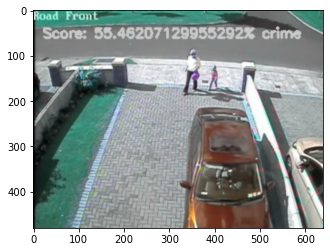

In [3]:
buffer = []
person = False
prev_pred = "Score: 0% crime"

# Test Variables (k=buffer size; videoname=video to test)
k=30
videoname = "normal3"
multiplier=2
outSize=(320*multiplier, 240*multiplier)

# Note: We're dealing with 30fps videos
# k = int(input("Enter buffer size:\t"))
# videoname = input("Enter a video name:\t")

cap = cv2.VideoCapture(f'./videos/{videoname}.mp4')


if cap.isOpened()==False:
    print("Either file not found or wrong codec used")

    
while cap.isOpened():
    
    ret, frame = cap.read()
    
    if ret==True:
        
        # Make a copy of your frame and resize it to pass it to model
        out = frame.copy()
        
        # DeepStack AI for detecting human
        response = detection.detectObject(out,output=None)
        for obj in response:
            
            # Make sure the DeepStack AI model can detect a human in the frame with atleast 75% confidence
            if obj.label=="person" and obj.confidence>0.75:
                person = True
            else:
                person = False

                
        # If you have a person in that frame, make prediction
        if person:
            out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
            out = cv2.resize(out, (320, 240)).astype("float32")
            pred = model.predict(np.expand_dims(out, axis=0))[0][0]
            
            # if the buffer is not full yet, show the current frames prediction alone
            if len(buffer)<k:
                buffer.append(1-pred)
                state = f"Score: {(1 - pred)*100}% crime"
                
            # else show the rolling avg of the previous k frame's prediction 
            else:
                buffer.pop(0)
                buffer.append(1-pred)
                state = f"Score: {(sum(buffer)/k)*100}% crime"
            prev_pred = state
        
        # Else don't waste time and show the previous frame's prediction
        else:
            state = prev_pred
        
        
        # Add the text showing the prediction to frame and display it
        frame = cv2.putText(frame, state, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 200, 200), 2)
        
        frame = cv2.resize(frame, outSize)
        cv2.imshow('frame',frame)
    
        # On pressing 'q' key quit and display the result of the last frame we encountered
        if cv2.waitKey(1) & 0xFF==ord('q'):
            print(f"Prediction at last frame:\n")
            plt.imshow(frame)
            break
    
    else:
        break

cap.release()
cv2.destroyAllWindows()